# Exploratory Data Analysis of PDF File

PDF document is downloaded and parsed, then exploratory data analysis including visualizations, topic modeling, and summarization is performed on entire document, as well as individual chapters.

In [21]:
# Standard imports
import numpy as np
import pandas as pd
# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# For offline notebook use
init_notebook_mode(connected=True)
cf.go_offline()

# Global plot settings
plt.rcParams.update({'axes.titlesize': 18,
                    'axes.labelsize': 16,
                    'xtick.labelsize': 14,
                    'ytick.labelsize': 14,
                    'legend.fontsize': 'small',
                    'figure.titlesize': 20,
                    'font.size': 16
                    })

# Visualization styles
sns.set_style('darkgrid')
sns.set_palette('viridis', 10)
# Mute warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Extracting Text

We'll first extract the text from the [source file](https://www.faa.gov/regulations_policies/handbooks_manuals/aircraft/media/amt_airframe_hb_vol_1.pdf).

I initially used the PyPDF2 library to search the text page by page to determine where the chapters start/end.

While an analysis of the text as a whole will be performed, I thought it may also be advantageous (or just interesting) to analyze text at the chapter level. Is this excessive? Possibly. But depending on what we want to do with this data, it could be useful - in particular, if we wanted to create chapter summaries or analyze topics by chapter.

After trying the PyPDF2 library for text extraction, I was unhappy with the output, and found that the tika library produced a more accurate extraction of the text, so we'll use the page information extracted with PyPDF2 in conjunction with the tika library to produce individual text files.

Using this information, we'll collect the text in separate documents as follows:
* Front Matter (anything before the start of the first chapter - Volume Contents, Preface, Acknowledgements, Table of Contents)
* Chapters (will be split into individual chapters)
* Back Matter (anything after the end of the last chapter - Glossary, Index)

### 1. Basic Text Information

In [1]:
# To download pdf
import urllib.request
# For text extraction
import PyPDF2 as pdf
from tika import parser
# For use of regex
import re
# For well-formatted dictionary printing
from pprint import pprint

In [2]:
# Download pdf from url
url = 'https://www.faa.gov/regulations_policies/handbooks_manuals/aircraft/media/amt_airframe_hb_vol_1.pdf'
urllib.request.urlretrieve(url, 'amt_airframe_hb_vol_1.pdf')

('amt_airframe_hb_vol_1.pdf', <http.client.HTTPMessage at 0x1badbe30a00>)

In [3]:
# Create pdf file object
file = open('amt_airframe_hb_vol_1.pdf', 'rb')

# Create pdf reader object
pdf_reader = pdf.PdfFileReader(file)

# Print number of pages
total_pages = pdf_reader.numPages
print(f'The document has {total_pages} pages.\n')

# Print document info
pprint(pdf_reader.getDocumentInfo())

The document has 584 pages.

{'/Author': 'FAA',
 '/CreationDate': "D:20180713163736-05'00'",
 '/Creator': 'Adobe InDesign CC 13.1 (Windows)',
 '/ModDate': "D:20180906152458-05'00'",
 '/Producer': 'Adobe PDF Library 15.0',
 '/Title': 'Aviation Maintenance Technician Handbook - Airframe Volume 1',
 '/Trapped': '/False'}


### 2. Finding chapter starting points

I extracted the first 40 or so pages and perused them to see if I could find how to identify the beginning of a chapter, finding that the first page of a chapter begins with something like "1-1Chapter1". Since the first pages of the document also included the table of contents, I was able to see that the last chapter was immediately followed by the glossary, so I collected the starting page of the glossary as well.

It wasn't sufficient to search just the table of contents for the chapter pages, since the pagination in the text was unique to the sections/chapters (i.e. '1-1'), and didn't match the standard 1, 2, 3, ... which will be used to loop through the document.

In [4]:
def find_chapters(reader):
    """Find starting points of chapters and glossary.

    Args:
        reader: pdf reader object.
    Returns:
        Dictionary of chapter and starting page pairs.

    """
    chapters ={}
    
    # Get number of pages
    pages = reader.numPages
    
    # Regex pattern for chapter number
    ch_pattern = re.compile('^\d-\d?\s?(Chapter\s\d?)')
    
    # Regex pattern for glossary start
    gl_pattern = re.compile('^G-\d?\s?(Glossary)')
    
    # Loop through pages
    for i in range(pages):
        
        # Get page text
        text = reader.getPage(i).extractText()
        
        # Search for pattern in page text
        ch_search = re.search(ch_pattern, text)
        gl_search = re.search(gl_pattern, text)
        
        # If no pattern is found, move to next page, otherwise add information to chapters list
        if ch_search is None and gl_search is None:
            continue
        elif gl_search:
            # Add pair 'G': starting page number to glossary
            chapters.update({'G': i})
        else:
            # Add pair chapter number: starting page number to chapters dictionary
            # We add 1 to the page number since indexing starts at 0 but pagination starts at 1
            chapters.update({int(ch_search.group(0).split()[1]): i + 1})
    
    return chapters

In [5]:
# Get list of chapters for document
chapter_map = find_chapters(pdf_reader)
pprint(chapter_map)

{1: 27, 2: 75, 3: 143, 4: 167, 5: 283, 6: 319, 7: 347, 8: 405, 9: 427, 'G': 532}


In [6]:
# Close original file
file.close()

### 3. Extracting text

We'll now use tika to save the xml content to a file.

Note: saving to a text file isn't necessary, as we'll store the output in the source_text variable, but in case we need this text data without re-scraping, we'll save it.

In [7]:
# Source file
source_file = 'amt_airframe_hb_vol_1.pdf'

def extract_pdf(file):
    """Extracts full text and saves to .txt file.

    Args:
        file: pdf file.
    Returns:
        Extracted text and metadata.

    """    
    # Open & parse file
    # Set xmlContent=True to include xml tags
    parsed_file = parser.from_file(file, xmlContent=True)
    
    # Get metadata of file
    data = parsed_file['metadata']
    
    # Get file title
    title = data['title']
    
    # Get content of file
    output = parsed_file['content']
    
    # utf-8 encoding
    output = output.encode('utf-8', errors='ignore')
    
    # Strip extra spaces
    output = output.strip()

    # Save content to output_<title>.txt file
    with open(f'./data/raw/output_{title}.txt', 'w') as new_file:
        new_file.write(str(output))
    
    # Return output & metadata
    return (output, data)

In [9]:
# Run extract_pdf on source file
source_text, source_data = extract_pdf(source_file)

Let's take a look at the document metadata.

In [10]:
# Print metadata - cell is minimized for space
pprint(source_data, compact=True)

{'Author': 'FAA',
 'Content-Type': 'application/pdf',
 'Creation-Date': '2018-07-13T21:37:36Z',
 'Last-Modified': '2018-09-06T20:24:58Z',
 'Last-Save-Date': '2018-09-06T20:24:58Z',
 'X-Parsed-By': ['org.apache.tika.parser.DefaultParser',
                 'org.apache.tika.parser.pdf.PDFParser'],
 'X-TIKA:content_handler': 'ToXMLContentHandler',
 'X-TIKA:embedded_depth': '0',
 'X-TIKA:parse_time_millis': '15678',
 'access_permission:assemble_document': 'true',
 'access_permission:can_modify': 'true',
 'access_permission:can_print': 'true',
 'access_permission:can_print_degraded': 'true',
 'access_permission:extract_content': 'true',
 'access_permission:extract_for_accessibility': 'true',
 'access_permission:fill_in_form': 'true',
 'access_permission:modify_annotations': 'true',
 'created': '2018-07-13T21:37:36Z',
 'creator': 'FAA',
 'date': '2018-09-06T20:24:58Z',
 'dc:creator': 'FAA',
 'dc:format': 'application/pdf; version=1.6',
 'dc:language': 'en-US',
 'dc:title': 'Aviation Maintenan

In [11]:
# Number of pages - we did this with PyPDF2, but let's verify things match up
total_pages = source_data['xmpTPg:NPages']
print(f'The document has {total_pages} pages.')

The document has 584 pages.


### 4. Writing individual files

We'll now use the BeautifulSoup library to write the front matter, chapters, and back matter to individual files.

In [12]:
# Import BeautifulSoup for parsing xml content
from bs4 import BeautifulSoup

In [13]:
# Create soup out of xml
# If opening from file, use:
# xml_soup = BeautifulSoup(open('./data/raw/output_Aviation Maintenance Technician Handbook - Airframe Volume 1.txt'), 'lxml')
xml_soup = BeautifulSoup(source_text, 'lxml')

In [14]:
# Store pages of soup in a list
# We'll add a placeholder at index 0 so the list indices match the page numbers
soup_pages = ['*']
soup_pages.extend(xml_soup.find_all('div', class_='page'))

In [15]:
def get_text_from_pages(pages, start, stop, filename):
    """Get text from page soup and save to .txt file.

    Args:
        pages: BeautifulSoup page list.
        start: Starting page.
        stop: Ending page.
        filename: Desired name for .txt file.

    """
    text = ''
    
    # Loop through pages
    for page in soup_pages[start:stop]:

        # Get text
        # Replace '\\n' with '\n'
        text += page.get_text().replace('\\n', '\n')
    
    # Write text to file
    with open(f'./data/raw/{filename}.txt', 'w+', encoding="utf-8") as f:
        f.write(text)

In [16]:
# Get front matter
get_text_from_pages(soup_pages, 1, chapter_map[1], 'front_matter')

# Integer chapter keys for looping (excluding glossary)
keys = [key for key in chapter_map.keys() if key != 'G']

# Get chapters
for key in keys:
    
    # Get starting page number for chapter
    ch_start = chapter_map[key]
    
    # If it's not the last chapter, set the stopping where the next chapter starts
    if key != 9:
        ch_stop = chapter_map[key + 1]
    # If it is the last chapter, set the stopping point where the glossary starts
    else:
        ch_stop = chapter_map['G']
    
    # Create file
    get_text_from_pages(soup_pages, ch_start, ch_stop, f'chapter_{key}')

# Get back matter
get_text_from_pages(soup_pages, chapter_map['G'], int(total_pages), 'back_matter')

I'ts magnificent! This gave me much better text output than looping through the pages with PyPDF2 (line breaks and characters got mangled a bit with PyPDF2).

## Creating corpora

We'll now create a corpus from our text files that we can then process for analysis.

In [17]:
# Import Natural Language Toolkit library
import nltk
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

In [18]:
# Download punkt, stopwords, words, wordnet packages
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


In [19]:
# Files to use
# If we want to exclude the front and back matter completely, we can slice [2:-2]
import os, sys
files = os.listdir('./data/raw')[1:-1]
files

['back_matter.txt',
 'chapter_1.txt',
 'chapter_2.txt',
 'chapter_3.txt',
 'chapter_4.txt',
 'chapter_5.txt',
 'chapter_6.txt',
 'chapter_7.txt',
 'chapter_8.txt',
 'chapter_9.txt',
 'front_matter.txt']

In [20]:
# Create corpus from files
newcorpus = PlaintextCorpusReader('./data/raw', files)

In [21]:
# Verify fileids
newcorpus.fileids()

['back_matter.txt',
 'chapter_1.txt',
 'chapter_2.txt',
 'chapter_3.txt',
 'chapter_4.txt',
 'chapter_5.txt',
 'chapter_6.txt',
 'chapter_7.txt',
 'chapter_8.txt',
 'chapter_9.txt',
 'front_matter.txt']

In [24]:
# Count various things from corpora
data = []
for fileid in newcorpus.fileids():
    # Number of characters
    num_chars = len(newcorpus.raw(fileid))
    # Number of words
    num_words = len(newcorpus.words(fileid))
    # Number of sentences
    num_sents = len(newcorpus.sents(fileid))
    # Number of paragraphs
    num_paras = len(newcorpus.paras(fileid))
    
    # Append counts and various levels of corpora to dictionary
    data.append({'fileid': fileid.split('.')[0], 
                 'characters': num_chars, 
                 'words': num_words, 
                 'sentences': num_sents, 
                 'paragraphs': num_paras,
                 'raw_text': newcorpus.raw(fileid),
                 'raw_words': newcorpus.words(fileid),
                 'raw_sents': newcorpus.sents(fileid),
                 'raw_paras': newcorpus.paras(fileid)
                })
    
# Create dataframe with counts and corpora levels for easy access later
df = pd.DataFrame(data)
df.set_index('fileid', inplace=True)

In [25]:
# View data
df.head()

,characters,words,sentences,paragraphs,raw_text,raw_words,raw_sents,raw_paras
fileid,,,,,,,,
back_matter,261351,39689,2640,1050,\r\n9-106\r\n\r\n\r\nG-1\r\n\r\nGlossary\r\n\r...,"(9, -, 106, G, -, 1, Glossary, Aborted, takeof...","([9, -, 106], [G, -, 1], [Glossary], [Aborted,...","([[9, -, 106]], [[G, -, 1]], [[Glossary]], [[A..."
chapter_1,118920,21675,1749,869,\r\n1-1\r\n\r\nChapter 1\r\n\r\nAircraft Struc...,"(1, -, 1, Chapter, 1, Aircraft, Structures, A,...","([1, -, 1], [Chapter, 1], [Aircraft, Structure...","([[1, -, 1]], [[Chapter, 1]], [[Aircraft, Stru..."
chapter_2,231626,41996,2949,1654,"\r\n2-1\r\n\r\nChapter 2\r\n\r\nAerodynamics, ...","(2, -, 1, Chapter, 2, Aerodynamics, ,, Aircraf...","([2, -, 1], [Chapter, 2], [Aerodynamics, ,, Ai...","([[2, -, 1]], [[Chapter, 2]], [[Aerodynamics, ..."
chapter_3,81097,14653,1017,476,\r\n3-1\r\n\r\nChapter 3\r\n\r\nAircraft Fabri...,"(3, -, 1, Chapter, 3, Aircraft, Fabric, Coveri...","([3, -, 1], [Chapter, 3], [Aircraft, Fabric, C...","([[3, -, 1]], [[Chapter, 3]], [[Aircraft, Fabr..."
chapter_4,364920,71216,6055,3728,\r\n4-1\r\n\r\nChapter 4\r\n\r\nAircraft Metal...,"(4, -, 1, Chapter, 4, Aircraft, Metal, Structu...","([4, -, 1], [Chapter, 4], [Aircraft, Metal, St...","([[4, -, 1]], [[Chapter, 4]], [[Aircraft, Meta..."


In [26]:
# Saving to .csv in case something goes horribly wrong and I don't want to repeat all of that
df.to_csv('./data/processed/dataframe.csv')

Let's collect some stats on average length of words/sentences/paragraphs of the raw text - we'll look at some visualizations of these later.

In [27]:
def get_average(item_list):
    """Get average length of word/sentence/paragraph.

    Args:
        item_list: list of items to get average lengths of.
    Return:
        Average length of list items.
    
    """
    return sum( map(len, item_list) ) / len(item_list)

In [29]:
# Apply to dataframe
df['avg_word_len'] = df['raw_words'].apply(get_average)
df['avg_sent_len'] = df['raw_sents'].apply(get_average)
df['avg_para_len'] = df['raw_paras'].apply(get_average)

In [121]:
# Save to file
df.to_csv('./data/processed/dataframe.csv')

# Save stats to separate dataframe/file - for easy access when creating visualizations
stats_df = df[['characters', 'words', 'sentences', 'paragraphs', 'avg_word_len', 'avg_sent_len', 'avg_para_len']]
stats_df.to_csv('./data/processed/stats_dataframe.csv')

## Processing Text

We will clean our data with the following pipeline:
* lowercase all words
* Remove stop words (we'll do this before removing punctuation since some stopwords have apostrophes)
* Remove hyphens - we do this at the word level and remove punctuation at character level
* Remove sentence punctuation (.?!)
* Remove remaining punctuation, and other special characters (this step was refactored after noticing Greek characters remained in text)
* Remove all numeric 'words'
* Remove nonsensical words
* lemmatize
* Return words that consist of more than 1 letter

### 1. Cleaning Text

In [33]:
# Import stopwords package
from nltk.corpus import stopwords
# For verifying nonsense words
from nltk.corpus import words 
# For lemmatizing
from nltk.stem import WordNetLemmatizer

In [169]:
# Text processing pipeline
# Note that checking for "good words" increases processing time significantly
def text_process(text, stops=True, hyph=True, sent_punc=True, sp_char=True, dig=True, good_words=True, lem=True, tokens=True):
    """Clean and process text.

    Args:
        text: text to process.
        stops: (optional) remove stop words.
        hyph: (optional) remove hyphens.
        sent-punc: (optional) remove sentence punctuation (.?!) only.
        sp_char: (optional) remove any non-alphanumeric characters (including punctuation).
        dig: (optional) remove 'words' consisting only of digits.
        good_words: (optional) remove nonsensical words.
        lem: (optional) lemmatize.
        tokens: (optional) return list of tokens. If False, returns string.
    Returns:
        Processed text.

    """
     # Collect stopwords
    stop = stopwords.words("english")
    
    # Collect sentence punctuation
    s_punc = '. ? !'.split()
    
    # Collect list of words to match against
    g_words = [word.lower() for word in words.words()]
    
    # Lowercase
    text = text.lower()
    
    if stops:
        # Lowercase & remove stop words
        text = ' '.join([word for word in text.split() if word not in stop])
    
    if hyph:
        # Replace hyphenation with space (without this, hyphenated words end up nonsensically concatenated after punctuation removal)
        text = re.sub(r'-', ' ', text)

    if sent_punc:
        # Remove sentence punctuation
        text = ''.join([char for char in text if char not in s_punc])
    
    if sp_char:
        # Remove all punctuation and non-english non-alphanumeric characters that are not whitespace
        text = re.sub(r'[^a-z\s\d\.\?\!]', '', text)
    
    if dig:
        # Remove things that consist of only digits
        text = re.sub(r'\d+', '', text)
        
    if good_words:
        # Remove nonsensical words
        text = ' '.join([word for word in text.split() if word in g_words])
    
    if lem:
        # Initialize lemmatizer
        lemmatizer = WordNetLemmatizer()
        # Lemmatize
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    if stops:
        # After initial analysis I refactored to add some other stop words that appeared frequently
        # We'll remove these words post-lemmatizing to be sure we catch all occurences
        new_stop = ['figure', 'figures', 'must', 'may', 'use', 'used']
        text = ' '.join([word for word in text.split() if word not in new_stop])
        
    # Strip extra whitespace from words and remove only single letter words
    tok = [word.strip() for word in text.split() if len(word) > 1]
    
    if tokens:
        # Return list of words
        return tok
    else:
        # Return string
        return ' '.join(tok)

We'll apply our processing pipeline when we vectorize our corpora.

In [170]:
# Testing output on Chapter 1
test = text_process(df.iloc[1]['raw_text'], good_words=True)
sorted(test)

['ability',
 'ability',
 'able',
 'able',
 'able',
 'able',
 'above',
 'above',
 'absorb',
 'absorbed',
 'absorbing',
 'absorbing',
 'absorbing',
 'acceptable',
 'access',
 'access',
 'access',
 'access',
 'access',
 'access',
 'access',
 'access',
 'access',
 'access',
 'accessory',
 'accessory',
 'accessory',
 'accompany',
 'accomplish',
 'accomplished',
 'accomplished',
 'accordance',
 'according',
 'achieve',
 'achieve',
 'achieve',
 'acronym',
 'across',
 'act',
 'act',
 'act',
 'act',
 'act',
 'act',
 'acting',
 'action',
 'action',
 'action',
 'action',
 'action',
 'activate',
 'activation',
 'active',
 'actual',
 'actual',
 'actually',
 'actually',
 'actually',
 'actually',
 'actually',
 'actuator',
 'added',
 'addition',
 'addition',
 'addition',
 'addition',
 'addition',
 'addition',
 'addition',
 'addition',
 'addition',
 'additional',
 'additional',
 'additional',
 'additionally',
 'additionally',
 'additionally',
 'additionally',
 'additionally',
 'adequately',
 'adjacent'

### 2. Vectorizing into a Bag of Words

In [36]:
# Load data from file - if necessary
# df = pd.read_csv('./data/processed/dataframe.csv')

In [37]:
# Import from scikit-learn
from sklearn.feature_extraction.text import CountVectorizer

In [171]:
# Fit vectorizer/build vocabulary using our text processing pipeline
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['raw_text'])

In [172]:
# Size of vocabulary
vocab_dict = bow_transformer.vocabulary_
print('Number of words in vocabulary: ', len(vocab_dict))

Number of words in vocabulary:  6086


In [173]:
# Let's check out what some of our feature names look like
bow_transformer.get_feature_names()[1:20]

['aaron',
 'ab',
 'aba',
 'abies',
 'ability',
 'able',
 'abnormal',
 'aborted',
 'above',
 'abrade',
 'abrasion',
 'abrasive',
 'abrupt',
 'abruptly',
 'absence',
 'absolute',
 'absorb',
 'absorbed',
 'absorbent']

In [174]:
# Transform into bag of words/document-term matrix
bow = bow_transformer.transform(df['raw_text'])

## Exploratory Data Analysis

After all that processing, it's finally time to see what we can learn from this data!

### 1. Basic Stats

Let's first compare some of the basic stats from our raw data that we computed above.

In [4]:
# to load data
stats_df = pd.read_csv('./data/processed/stats_dataframe.csv', index_col=0)
stats_df.drop('characters', inplace=True, axis=1)

In [5]:
# Rename columns and view
col_names = ['num of words', 'num of sentences', 'num of paragraphs', 'avg characters per word', 'avg words per sentence', 'avg sentences per paragraph']
stats_df.columns = col_names
stats_df

,num of words,num of sentences,num of paragraphs,avg characters per word,avg words per sentence,avg sentences per paragraph
fileid,,,,,,
back_matter,39689,2640,1050,5.559979,15.033712,2.514286
chapter_1,21675,1749,869,4.354648,12.392796,2.012658
chapter_2,41996,2949,1654,4.372916,14.241099,1.782950
chapter_3,14653,1017,476,4.412885,14.408063,2.136555
chapter_4,71216,6055,3728,3.976915,11.761685,1.624195
chapter_5,25124,1634,849,4.149698,15.375765,1.924617
chapter_6,14369,1062,625,4.248591,13.530132,1.699200
chapter_7,36044,2566,1267,4.322606,14.047155,2.025257
chapter_8,15830,884,368,4.353822,17.907240,2.402174


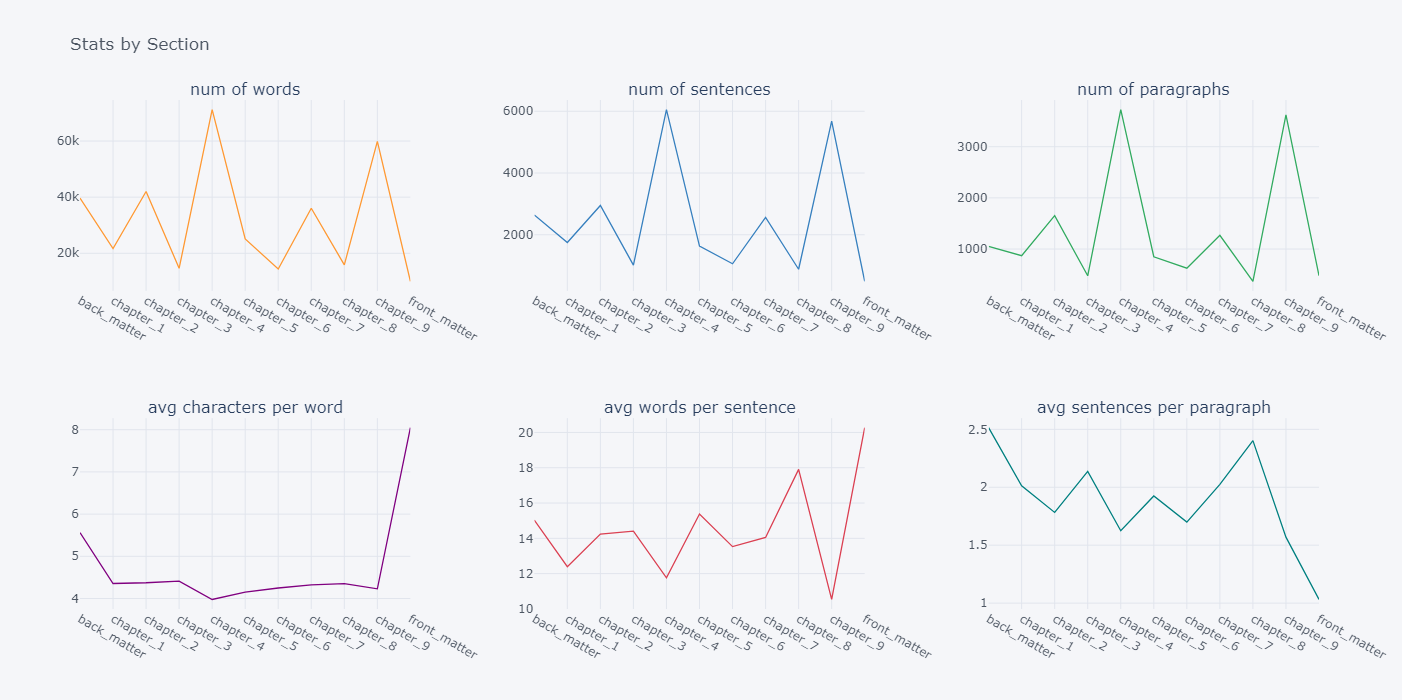

In [25]:
# Generate Interactive plots
stats_df.reset_index().iplot(x='fileid', 
               title='Stats by Section', 
               subplots=True, 
               shape=(2,3),
               horizontal_spacing=0.1,
               vertical_spacing=0.25,
               dimensions=(1300,700),
               subplot_titles=True,
               layout_update=dict(showlegend=False));

In [27]:
# If interactive plot doesn't display, uncomment and run the followng
#from IPython.display import IFrame
#IFrame(src='./int_plot.html', width=1300, height=700)

Chapter 4 appears to be the longest chapter and 8 the shortest. The front matter includes the longest words and sentences, while the back matter has the longest paragraphs. If we disregard front and back matter, chapter 8 has the longest sentences and paragraphs. Chapter 9 has the shortest sentences and paragraphs.

### 2. Document-Term Matrix
Let's check the shape of our document-term matrix.

In [176]:
print('Shape of Document-Term Matrix: ', bow.shape)

Shape of Document-Term Matrix:  (11, 6086)


We have 11 documents (front matter, chapters 1-9, back matter) with a combined 6086 words.

In [177]:
# Nonzero occurences
print('Number of nonzero occurences: ', bow.nnz)

Number of nonzero occurences:  20356


In [178]:
# Sparsity
sparsity = (100 * bow.nnz / (bow.shape[0] * bow.shape[1]))
print(f'Sparsity: {sparsity}')
print(f'Sparsity (rounded): {round(sparsity)}')

Sparsity: 30.40659636124638
Sparsity (rounded): 30


In [179]:
# Viewing as a dataframe
columns = bow_transformer.get_feature_names()

# Put matrix in dataframe form
dt_matrix = pd.DataFrame(bow.toarray(), columns=columns, index=df.index)

# Save to file
dt_matrix.to_csv('./data/processed/dt_matrix.csv')

# View
dt_matrix

,aa,aaron,ab,aba,abies,ability,able,abnormal,aborted,above,...,yoke,york,young,zee,zeppelin,zero,zinc,zip,zirconium,zone
fileid,,,,,,,,,,,,,,,,,,,,,
back_matter,1,0,0,0,0,0,4,1,2,0,...,3,0,0,0,2,10,3,0,0,2
chapter_1,0,0,0,0,0,2,4,0,0,2,...,3,0,0,0,0,4,0,0,0,11
chapter_2,1,0,0,0,0,2,2,2,0,4,...,1,2,1,0,0,6,0,0,0,0
chapter_3,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,1,0,0,0
chapter_4,0,0,0,0,0,4,2,0,0,1,...,3,0,0,2,0,0,1,2,1,0
chapter_5,2,0,3,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
chapter_6,2,0,0,0,2,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
chapter_7,0,0,0,0,0,3,2,0,0,0,...,2,0,0,0,0,9,0,0,0,7
chapter_8,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,10,0,0,0


### 3. Term Frequency - Inverse Document Frequency

In [60]:
# Import from scikit-learn
from sklearn.feature_extraction.text import TfidfTransformer

In [180]:
# Instantiate and fit transformer
tfidf_transformer = TfidfTransformer().fit(bow)

In [181]:
# Transform
tfidf = tfidf_transformer.transform(bow)

In [182]:
# Verify shape of matrix
tfidf.shape

(11, 6086)

In [183]:
# Put matrix in dataframe form
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns=columns, index=df.index)

# Save to file
tfidf_matrix.to_csv('./data/processed/tfidf_matrix.csv')

# View
tfidf_matrix

,aa,aaron,ab,aba,abies,ability,able,abnormal,aborted,above,...,yoke,york,young,zee,zeppelin,zero,zinc,zip,zirconium,zone
fileid,,,,,,,,,,,,,,,,,,,,,
back_matter,0.002199,0.00000,0.000000,0.000000,0.000000,0.000000,0.006593,0.002461,0.006548,0.000000,...,0.005957,0.000000,0.000000,0.000000,0.006548,0.019855,0.005957,0.000000,0.000000,0.004399
chapter_1,0.000000,0.00000,0.000000,0.000000,0.000000,0.004460,0.008919,0.000000,0.000000,0.005373,...,0.008059,0.000000,0.000000,0.000000,0.000000,0.010745,0.000000,0.000000,0.000000,0.032731
chapter_2,0.001775,0.00000,0.000000,0.000000,0.000000,0.002661,0.002661,0.003973,0.000000,0.006411,...,0.001603,0.005285,0.002643,0.000000,0.000000,0.009617,0.000000,0.000000,0.000000,0.000000
chapter_3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008017,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002672,0.000000,0.000000,0.000000
chapter_4,0.000000,0.00000,0.000000,0.000000,0.000000,0.003273,0.001637,0.000000,0.000000,0.000986,...,0.002958,0.000000,0.000000,0.003251,0.000000,0.000000,0.000986,0.003251,0.001626,0.000000
chapter_5,0.003838,0.00000,0.008569,0.002856,0.000000,0.001438,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005757
chapter_6,0.008219,0.00000,0.000000,0.000000,0.012234,0.009239,0.000000,0.004598,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chapter_7,0.000000,0.00000,0.000000,0.000000,0.000000,0.004706,0.003137,0.000000,0.000000,0.000000,...,0.003779,0.000000,0.000000,0.000000,0.000000,0.017007,0.000000,0.000000,0.000000,0.014652
chapter_8,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.006403,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038570,0.000000,0.000000,0.000000


In [65]:
# To load matrix data
# dt_matrix = pd.read_csv('./data/processed/dt_matrix.csv', index_col=0)
# tfidf_matrix = pd.read_csv('./data/processed/tfidf_matrix.csv', index_col=0)

### 4. Word Occurence Visualizations

In [66]:
# For making wordclouds
from wordcloud import WordCloud

First, we'll look at some histograms. We'll focus on the main content, i.e. Chapters 1-9. We can easily adjust to include front and back matter, if desired.

In [336]:
def chap_grid(plot_title, xlabel=None, ylabel=None, figsize=(18,18)):
    """Sets up consistent grid styles for plots by chapter.

    Args:
        plot_title: title of entire plot.
        xlabel: (optional) y-axis label for entire plot.
        ylabel: (optional) x-axis label for entire plot.
        figsize: (optional) figure size for entire plot.
    Returns:
        Figure, axes.

    """
    # Set up plot grid
    fig, axs = plt.subplots(nrows = 3, ncols=3, figsize=figsize)

    # Title and labels
    fig.suptitle(plot_title, y=0.95)
    if xlabel:
        fig.text(0.5, 0.03, xlabel, ha='center')
    if ylabel:
        fig.text(0.01, 0.5, ylabel, va='center', rotation='vertical')

    # Adjust spacing
    fig.subplots_adjust(hspace=0.2, wspace=0.4, left=0.1, bottom=0.1)

    return [fig, axs]

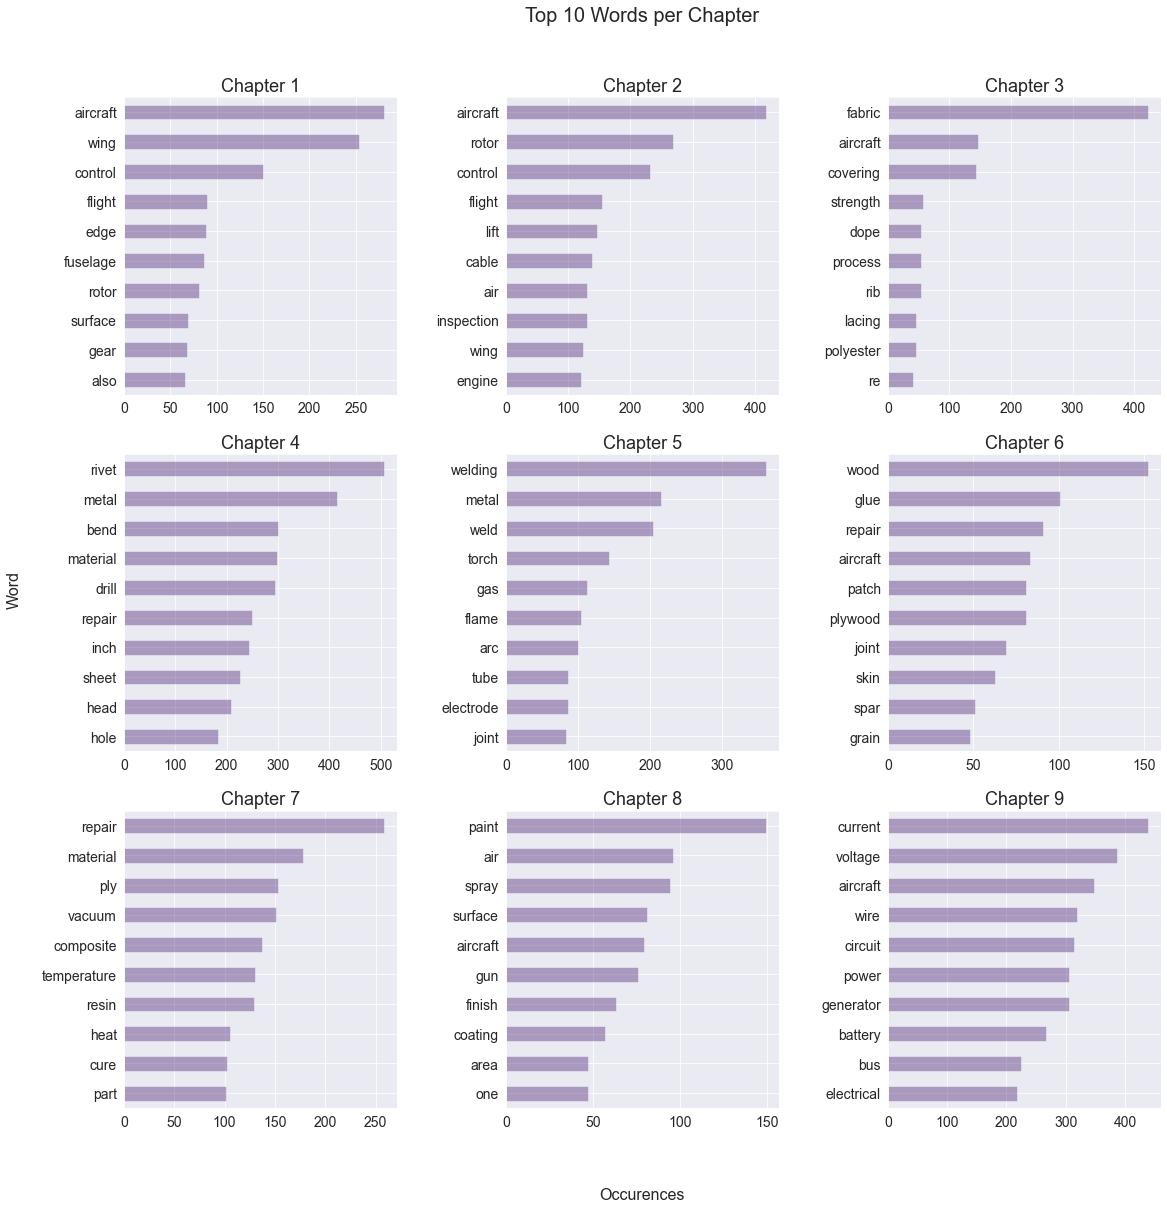

In [338]:
# Plot top 10 words per chapter
fig, axs = chap_grid('Top 10 Words per Chapter', 'Occurences', 'Word')

for i, ax in enumerate(axs.flatten()):
    # Get top 10 occurences
    data = dt_matrix.iloc[i+1].sort_values(ascending=False)[0:10].sort_values()
    # Plot details
    fig.add_subplot(ax)
    ax.set_title(f'Chapter {i+1}')
    data.plot(kind='barh', alpha=0.4)

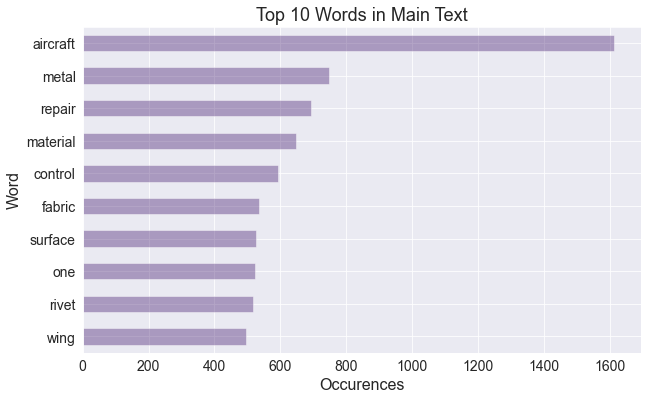

In [186]:
# 10 most frequent words in all chapters together
top_10 = dt_matrix.drop(index=['front_matter', 'back_matter']).sum().sort_values(ascending=False)[0:10].sort_values()

# Styling
plt.figure(figsize=(10,6))
plt.title('Top 10 Words in Main Text', fontsize=18)
plt.xlabel('Occurences', fontsize=16)
plt.ylabel('Word', fontsize=16)
top_10.plot(kind='barh', alpha=0.4, fontsize=14);

Now we'll look at a much more entertaining visualization, the word cloud!

Let's start with the top 100 words of the main text.

In [74]:
def gen_wordcloud(freq_dict, title=None, titlesize=0, figsize=None):
    """Generates and plots word cloud.

    Args:
        freq_dict: dictionary of words and associated frequencies.
        title: (optional) word cloud title.
        titlesize: (optional) font size for title.
        figsize: (optional) figure size for word cloud.

    """
    wordcloud = WordCloud(width=1000, height=500, background_color='black').generate_from_frequencies(freq_dict)
    if figsize:
        plt.figure(figsize=figsize)
    if title:
        plt.title(title, fontsize=titlesize)
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')

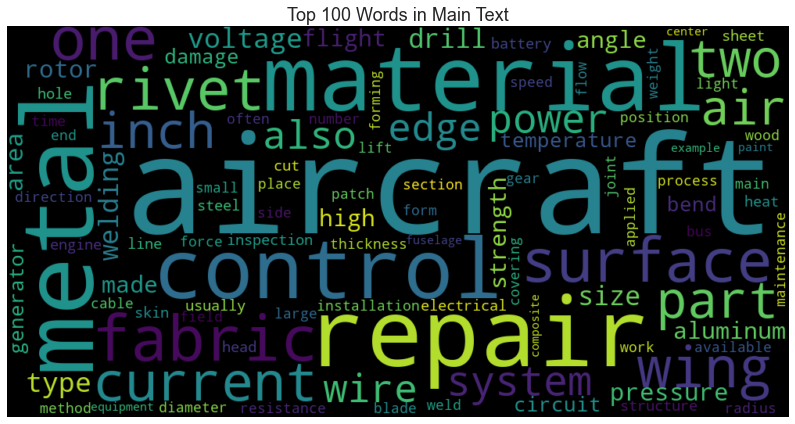

In [187]:
# Top 100 words in chapters 1-9
top_100 = dt_matrix.drop(index=['front_matter', 'back_matter']).sum().sort_values(ascending=False)[0:100]

gen_wordcloud(top_100.to_dict(), 'Top 100 Words in Main Text', 18, (14,14))

The word cloud indicates that the document is concerned with aircraft repair and materials.

Now let's look at the top 50 in each chapter.

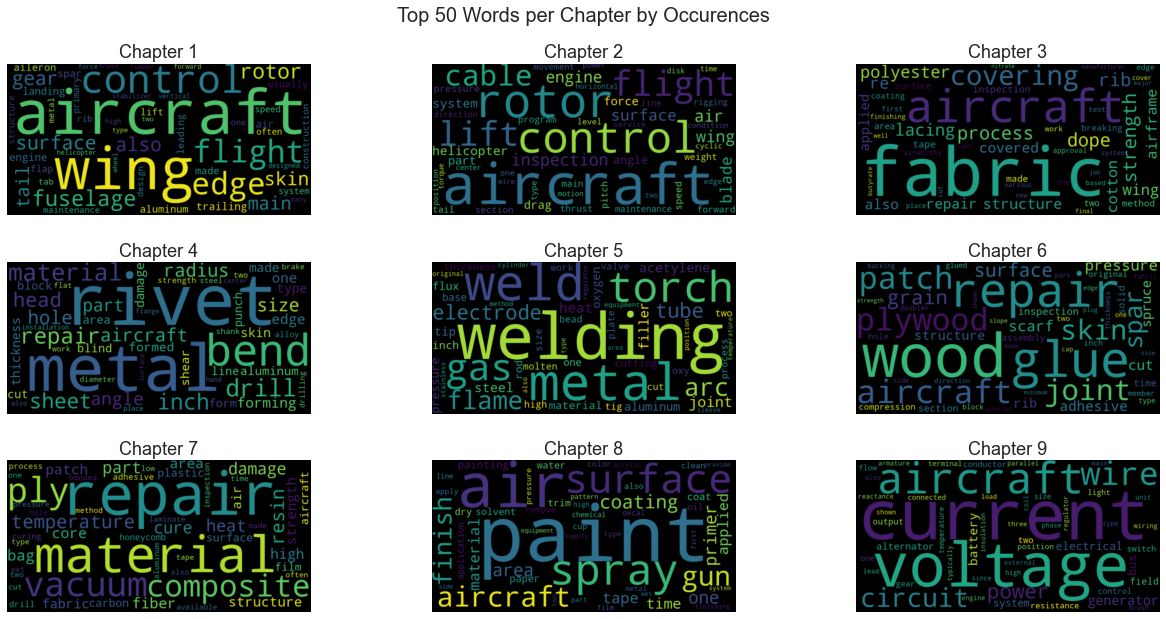

In [340]:
fig, axs = chap_grid('Top 50 Words per Chapter by Occurences', figsize=(20,10))

for i, ax in enumerate(axs.flatten()):
    # Get top 50 words in chapter
    data = dt_matrix.iloc[i+1].sort_values(ascending=False)[0:50]
    # Plot details
    fig.add_subplot(ax)
    ax.set_title(f'Chapter {i+1}')
    gen_wordcloud(data.to_dict())

This is pretty cool - We can see general topics appearing from each word cloud.

### 5. TF-IDF Visualizations

Let's also look at the top words by mean TF-IDF.

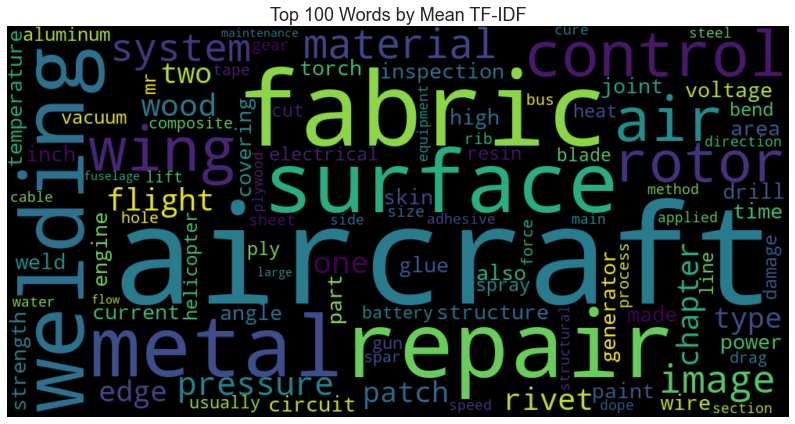

In [189]:
# Top 100 Mean TF-IDF - including front/back matter, switch commenting of next two lines to exclude
# top_100_tf = tfidf_matrix.drop(index=['front_matter', 'back_matter']).mean().sort_values(ascending=False)[0:100]
top_100_tf = tfidf_matrix.mean().sort_values(ascending=False)[0:100]

gen_wordcloud(top_100_tf.to_dict(), 'Top 100 Words by Mean TF-IDF', 18, (14,14))

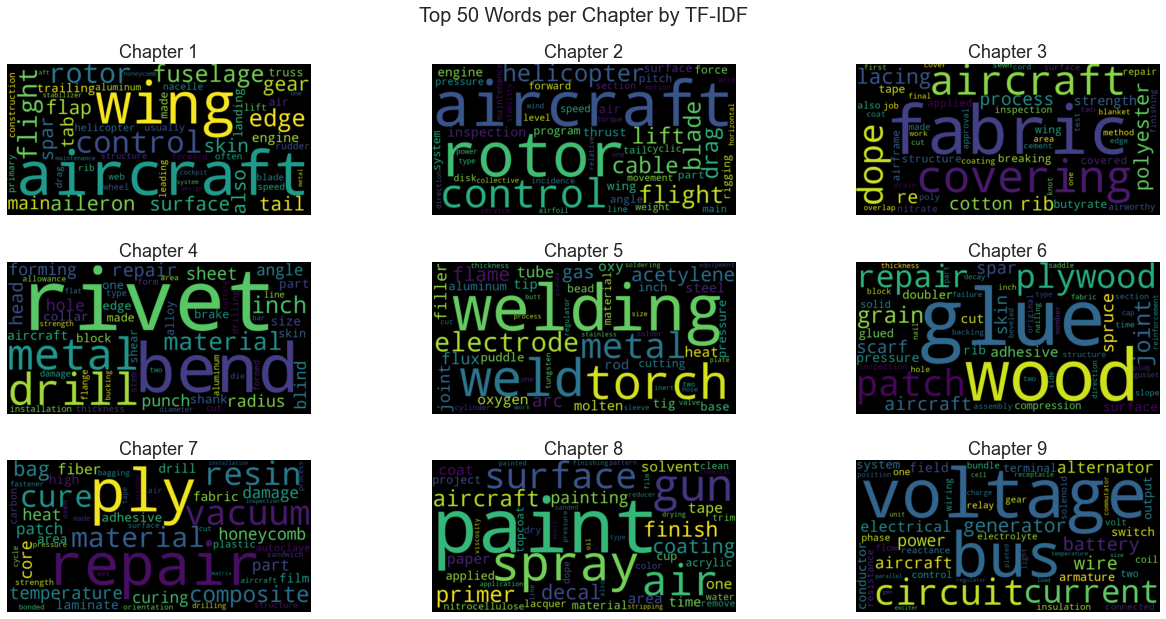

In [341]:
# Let's check out chapter wordclouds by TF-IDF
fig, axs = chap_grid('Top 50 Words per Chapter by TF-IDF', figsize=(20,10))

for i, ax in enumerate(axs.flatten()):
    # Get 50 highest TF-IDF per chapter
    data = tfidf_matrix.iloc[i+1].sort_values(ascending=False)[0:50]
    # Plot details
    fig.add_subplot(ax)
    ax.set_title(f'Chapter {i+1}')
    gen_wordcloud(data.to_dict())

These TF-IDF word clouds give us a better idea of the words that are specifically relevant to each chapter, though they do not appear to vary much from our occurence word clouds.

Looking at both sets of word clouds, we can get a general sense of the following:
* Chapter 1 is about aircraft structure
* Chapter 2 is about aircraft flight/control
* Chapter 3 is about fabric
* Chapter 4 is about riveted metal
* Chapter 5 is about welding
* Chapter 6 is about wood repair
* Chapter 7 is about composite material repair
* Chapter 8 is about painted surfaces
* Chapter 9 is about electrical circuitry

### 6. Summarization

Let's look at short (100 word) summaries of each chapter, and chapters 1-9 as a whole.

In [81]:
# For creating summaries
from gensim.summarization.summarizer import summarize

In [82]:
def print_summary(summary, title):
    """Formatted summary printing.

    Args:
        summary: text to print.
        title: title of summary.
        
    """
    print(f'\n{title} summary:')
    print('-----------------------')
    print(summary)

In [84]:
def gen_summary(text, count=100, p=False, title=None):
    """Generates and prints summary.

    Args:
        text: text to summarize.
        count: (optional) number of words to include in summary.
        p: (optional) rints summary if True.
        title: (optional) title for printing.
    Returns:
        Summarized text.
        
    """
    # Small amount of processing on text - just lowercase
    proc_text = text.lower()
    
    # Summarize
    summ = summarize(proc_text, word_count=count)
    
    if p:
        print_summary(summ, title)
    else:
        return summ

In [85]:
# Generate and save chapter summaries to dataframe
df['summary'] = df['raw_text'].apply(gen_summary)

In [157]:
# Save updated df
df.to_csv('./data/processed/dataframe.csv')

In [88]:
# Print summaries
df.reset_index()[['summary', 'fileid']].apply(lambda x: print_summary(*x), axis=1);


back_matter summary:
-----------------------
and the static pressure of the air surrounding the aircraft.
electrical power, compressed air, and hydraulic pressure 
pumps provide a positive flow of fuel under pressure to the 
connect an alternating current generator to an aircraft engine.
a type of finishing material that flows out to form 
control surface on an aircraft that is caused by a dynamically 
a type of flow control valve that allows 
fuel tanks of turbine-engine-powered aircraft that is caused 
in an aircraft hydraulic system, pressure relief valves 
a pressure wave formed in the air by a flight 
a type of hydraulic system-pressure control valve.
aircraft metal structural repair .......................................4-1

chapter_1 summary:
-----------------------
wing panels, flight control surfaces, cabin floor boards, and 
units: the fuselage, wings, stabilizers, flight control surfaces, 
the wings of an aircraft can be attached to the fuselage at 
the wings of an aircraf

In [89]:
# Chapters 1-9 Summary - word count was increased to 200

# Concatenate chapters 1-9 text
text = ''
for i in range(1,10):
    text += df['raw_text'][i]

# Summarize
gen_summary(text, count=200, p=True, title='Chapters 1-9')


Chapters 1-9 summary:
-----------------------
core honeycomb panels are frequently used as flight control surfaces and wing trailing edges.
a wing leading edge formed from honeycomb material bonded to the aluminum spar structure.
the directional control of a fixed-wing aircraft takes place 
the primary flight control surfaces on a fixed-wing aircraft 
note that the control surfaces of fabric-covered aircraft 
(light) aircraft typically have all-aluminum control surfaces.
typical flight control surfaces on a transport category aircraft.
an aileron balance panel and linkage uses varying air pressure to assist in control surface positioning.
on heavy aircraft, large control surfaces require too much 
repairs to a control surface or its tabs generally increase the 
aircraft manufacturers use different materials to balance 
the repair of common damage to a specific aircraft structure.
aircraft metal structural repair
aircraft metal structural repair
as discussed in chapter 3, aircraft fabr

The 100 word summary was not very informative, so I increased to 200. A larger word count may produce a better result. 

I experimented with processing the text a bit (removing special characters/digits) pre-summarizing, but found the summaries to be more informative when just the raw text was used.

Summaries appear to coincide with our analysis from the wordclouds.

### 5. Topic modeling with LDA

In [225]:
# Import lda model & tools
from gensim.models import LdaMulticore
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary

In [255]:
# Switch order of key/value in vocab dictionary to prepare for lda
word2id = vocab_dict.items()
id2word = {y:x for x,y in word2id}
# Convert sparse matrix (doc-term matrix) to gensim corpus to prepare for lda
corpus = Sparse2Corpus(bow, documents_columns=False)
# Create gensim dictionary
g_dict = Dictionary.from_corpus(corpus, id2word=id2word)

In [321]:
# Build model
lda = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=25, passes=10)

In [322]:
# Visualizing LDA results
import pyLDAvis
import pyLDAvis.gensim

# Enable notebook mode
pyLDAvis.enable_notebook()

In [323]:
# Prepare visualizations
lda_vis = pyLDAvis.gensim.prepare(lda, corpus, g_dict)

In [324]:
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.180516  0.027243       1        1  19.855592
16     0.151418 -0.128231       2        1  17.226394
14     0.155880 -0.155543       3        1  12.851340
17     0.175870  0.077521       4        1  10.640584
13     0.142100 -0.106891       5        1  10.476027
15     0.167738  0.042759       6        1   7.762406
3      0.167342 -0.139629       7        1   7.633387
6      0.154688  0.119452       8        1   5.250376
18     0.183785  0.123498       9        1   4.163358
10     0.184082  0.104612      10        1   4.135282
0     -0.113548  0.003006      11        1   0.000350
23    -0.087913  0.014611      12        1   0.000350
22    -0.115529  0.005523      13        1   0.000350
21    -0.094574 -0.010649      14        1   0.000350
20    -0.117130  0.000924      15        1   0.000350
19    -0.107543  0.004996      16        1   0.000350
12    -0.112687 -0.004520      17        1   0.000350
1     -0.127234  0.005618      18        1   0.000350
11    -0.114263  0.006426      19        1   0.000350
9     -0.108351 -0.003701      20        1   0.000350
8     -0.108565  0.001804      21        1   0.000350
7     -0.112017  0.002390      22        1   0.000350
4     -0.110124  0.000785      23        1   0.000350
2     -0.115078  0.000858      24        1   0.000350
24    -0.118865  0.007138      25        1   0.000350, topic_info=          Term         Freq        Total Category  logprob  loglift
153   aircraft  1875.000000  1875.000000  Default  30.0000  30.0000
417     fabric   593.000000   593.000000  Default  29.0000  29.0000
631      rivet   557.000000   557.000000  Default  28.0000  28.0000
300      metal   851.000000   851.000000  Default  27.0000  27.0000
563    welding   441.000000   441.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
324        cut     0.000128   258.232406  Topic25  -8.1441  -1.9557
1888     paint     0.000124   182.831918  Topic25  -8.1766  -1.6428
31         two     0.000134   485.133733  Topic25  -8.1014  -2.5435
435       area     0.000131   380.747652  Topic25  -8.1204  -2.3203
55       power     0.000130   476.848393  Topic25  -8.1301  -2.5550

[1851 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5137     10  0.872963       abies
5304      8  0.949593      abrade
7         3  0.108221    absolute
7         5  0.865766    absolute
5255      4  0.911669  absorption
...     ...       ...         ...
981       7  0.027234        work
981       8  0.059007        work
981       9  0.090780        work
981      10  0.054468        work
4120      9  0.740202    workshop

[2392 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 17, 15, 18, 14, 16, 4, 7, 19, 11, 1, 24, 23, 22, 21, 20, 13, 2, 12, 10, 9, 8, 5, 3, 25])

In [325]:
# Loop through LDA corpus to find highest topic for each document
topic_data = []

for doc_id, topic_list in enumerate(lda[corpus]):
    
    # Sort topic list by percentages
    topics = sorted(topic_list, key=lambda x: x[1], reverse=True)
    
    # Grab highest topic and percentage
    top_id = topics[0][0]
    top_pr = topics[0][1]
    
    # Grab topic keywords
    keywords = [word for word, val in lda.show_topic(top_id)]
    
    topic_data.append({'main_topic': top_id, 'percent': top_pr, 'keywords': keywords})

# Create dataframe
topics = pd.DataFrame(topic_data, index=df.index)

# Save dataframe
topics.to_csv('./data/processed/topics.csv')

In [326]:
def print_topics(doc, topic, percent, keywords):
    """Prints information from topics dataframe.

    Args:
        document: document name.
        topic: main topic.
        percent: topic percent in document.
        keywords: topic keywords

    """
    print(f'\n{doc}')
    print('-----------------------')
    print(f'main topic: {topic}')
    print(f'topic percentage: {percent}')
    print(f'topic keywords: {", ".join(keywords)}')

In [327]:
# Print topic summary
topics.apply(lambda x: print_topics(x.name, x['main_topic'], x['percent'], x['keywords']), axis=1);


back_matter
-----------------------
main topic: 13
topic percentage: 0.8671901822090149
topic keywords: system, aircraft, pressure, air, fluid, metal, fuel, valve, type, electrical

chapter_1
-----------------------
main topic: 3
topic percentage: 0.9998817443847656
topic keywords: aircraft, wing, control, chapter, image, flight, rotor, edge, fuselage, gear

chapter_2
-----------------------
main topic: 14
topic percentage: 0.9999364614486694
topic keywords: aircraft, rotor, control, flight, lift, cable, air, inspection, wing, engine

chapter_3
-----------------------
main topic: 18
topic percentage: 0.9998140335083008
topic keywords: fabric, aircraft, covering, strength, process, dope, rib, lacing, polyester, re

chapter_4
-----------------------
main topic: 5
topic percentage: 0.9999610185623169
topic keywords: rivet, metal, bend, drill, material, repair, inch, sheet, head, hole

chapter_5
-----------------------
main topic: 15
topic percentage: 0.99989914894104
topic keywords: weld

## Conclusions and Afterthoughts

There's always so much more to be done, but overall, I think we've gained decent insight into the content of this file.

We can see from the metadata that this is an FAA document titled 'Aviation Maintenance Technician Handbook - Airframe Volume 1.' If the title wasn't enough, topic and word frequency analysis shows that this is a document concerned with maintenance and repair of various materials on an aircraft. The generated summary of the front matter explicitly states "this volume contains information on airframe construction features, assembly and rigging, fabric covering, structural repairs."

Analysis on the main chapters of the document finds the following simple descriptions of the chapters:
* **Chapter 1:** Aircraft structure
* **Chapter 2:** Aerodynamics & control
* **Chapter 3:** Fabric
* **Chapter 4:** Riveted metal
* **Chapter 5:** Welding
* **Chapter 6:** Wood
* **Chapter 7:** Other (composite) material
* **Chapter 8:** Paint
* **Chapter 9:** Electrical components

Some areas for improvement:
* There are a lot of images in this file that aren't accounted for, using an OCR library like textract might help gain more insight.
* I ended up parsing the full document twice (once to find chapter cutoffs, and once to collect the xml/text) - it would be better to do this once only, as it was time consuming.
* Removing 'words' consisting only of digits can lead to loss of information, for instance, it's possible there are years or other numeric features of interest.
* Treating parts of hyphenated words as individual words can lead to loss of information (particularly with proper nouns and words prefixed with things like "re-").
* Text processing when transforming to BOW was time consuming because of the check for "good words".
* Implementing logging before summarizing would have been useful - summarizing was a time consuming process.
* Topic modeling can be improved by filtering out features with low frequencies and tagging features by part of speech.
* Once we understand this is a document about aircraft maintenance, adding the word 'aircraft' to our stop words list may provide more specific details of each chapter and make for beter topic analysis.
* Analysis of bigrams/n-grams may provide more detailed insight.